<a href="https://colab.research.google.com/github/Kinnaruo/DeepLearning/blob/main/Week2/Compressed_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

In [4]:
df = pd.read_csv('compressed_data.csv.gz')
df.dropna(inplace=True)
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,1,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,1,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,1,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,1,0,3


In [5]:
X = df.drop(columns=["Cover_Type"]).values
y = df["Cover_Type"].values

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#PyTorch

In [6]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [9]:
class MLP_Torch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP_Torch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

torch_model = MLP_Torch(X_train.shape[1], len(np.unique(y)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = torch_model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()

In [10]:
y_pred_torch = torch.argmax(torch_model(X_test_torch), dim=1).numpy()

# Tensorflow

In [11]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')
])

model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_tf.fit(X_train, y_train, epochs=100, verbose=0)
y_pred_tf = np.argmax(model_tf.predict(X_test), axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [13]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

acc_torch, prec_torch, rec_torch, f1_torch = evaluate_model(y_test, y_pred_torch)
acc_tf, prec_tf, rec_tf, f1_tf = evaluate_model(y_test, y_pred_tf)

print(f"PyTorch:\nAcc: {acc_torch:.4f}\nPrec: {prec_torch:.4f}\nRec: {rec_torch:.4f}\nF1: {f1_torch:.4f}")
print(f"TensorFlow:\nAcc: {acc_tf:.4f}\nPrec: {prec_tf:.4f}\nRec: {rec_tf:.4f}\nF1: {f1_tf:.4f}")

PyTorch:
Acc: 0.6830
Prec: 0.6713
Rec: 0.6830
F1: 0.6564
TensorFlow:
Acc: 0.8795
Prec: 0.8815
Rec: 0.8795
F1: 0.8794


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3632/3632 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step


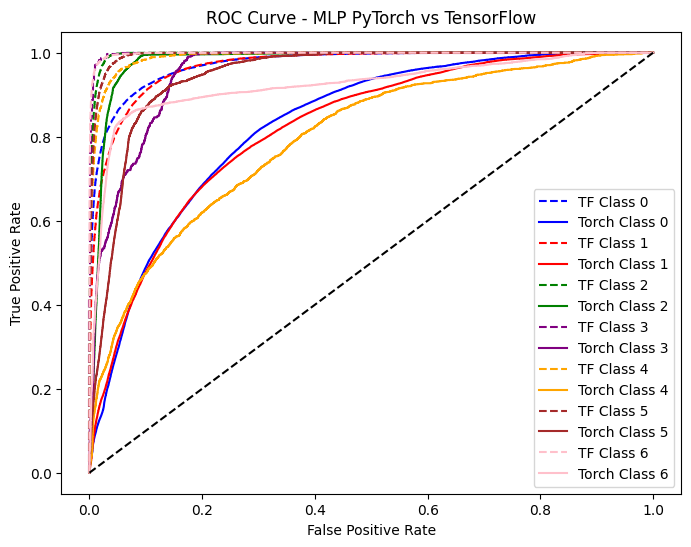

In [14]:
y_test_bin = tf.keras.utils.to_categorical(y_test)
y_prob_tf = model_tf.predict(X_test)
y_prob_torch = torch.nn.functional.softmax(torch_model(X_test_torch), dim=1).detach().numpy()

plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange", "brown", "pink"])
for i, color in zip(range(len(np.unique(y))), colors):
    fpr_tf, tpr_tf, _ = roc_curve(y_test_bin[:, i], y_prob_tf[:, i])
    fpr_torch, tpr_torch, _ = roc_curve(y_test_bin[:, i], y_prob_torch[:, i])
    plt.plot(fpr_tf, tpr_tf, color=color, linestyle='--', label=f'TF Class {i}')
    plt.plot(fpr_torch, tpr_torch, color=color, label=f'Torch Class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP PyTorch vs TensorFlow")
plt.legend()
plt.show()

# Matriks Evaluasi
## **Accuracy**
Accuracy mengukur seberapa sering model membuat prediksi yang benar dibandingkan dengan total data.

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

Di mana:  
- $TP$ = True Positive  
- $TN$ = True Negative  
- $FP$ = False Positive  
- $FN$ = False Negative  

Semakin tinggi **accuracy**, semakin baik performa model secara keseluruhan.

## **Precision**
Precision mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan total prediksi positif.

$$
Precision = \frac{TP}{TP + FP}
$$

Precision tinggi berarti model jarang salah dalam memprediksi kelas positif. Berguna ketika **false positive** harus diminimalkan, misalnya dalam **deteksi kanker**.

## **Recall**
Recall mengukur seberapa banyak sampel positif yang benar-benar terdeteksi oleh model.

$$
Recall = \frac{TP}{TP + FN}
$$

Recall tinggi berarti model tidak melewatkan banyak sampel positif. Sangat penting dalam **deteksi penyakit atau penipuan**, di mana **false negative** harus diminimalkan.

##**F1 Score**
F1 Score adalah rata-rata harmonik antara Precision dan Recall. Berguna saat dataset tidak seimbang.

$$
F1\ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$

F1 Score tinggi berarti keseimbangan yang baik antara Precision dan Recall.

## **ROC dan AUC**
ROC (**Receiver Operating Characteristic**) adalah kurva yang menunjukkan trade-off antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**.

$$
TPR = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{FP + TN}
$$

Jika nilai semakin mendekati 1, semakin bagus modelnya. Sedangkan jika nilai di bawah 0.5, model tersebut lebih buruk dari tebakan acak.